In [5]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn.functional as F
import numpy as np

# Step 1: Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the images
])

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)




Files already downloaded and verified


In [10]:
# Step 2: Load pretrained ResNet-34 model



import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

# Define transformations for the dataset
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Define the ResNet-34 model
model = models.resnet34(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)  # 10 classes in CIFAR-10
model = model.cuda()  # Move the model to GPU if available

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Train the model
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].cuda(), data[1].cuda()  # Move data to GPU
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:  # Print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

print('Finished Training')

# Test the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].cuda(), data[1].cuda()  # Move data to GPU
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))



Files already downloaded and verified
Files already downloaded and verified
[1,   100] loss: 2.259
[1,   200] loss: 1.948
[1,   300] loss: 1.813
[2,   100] loss: 1.674
[2,   200] loss: 1.620
[2,   300] loss: 1.598
[3,   100] loss: 1.531
[3,   200] loss: 1.491
[3,   300] loss: 1.480
[4,   100] loss: 1.418
[4,   200] loss: 1.394
[4,   300] loss: 1.406
[5,   100] loss: 1.336
[5,   200] loss: 1.333
[5,   300] loss: 1.331
[6,   100] loss: 1.292
[6,   200] loss: 1.266
[6,   300] loss: 1.251
[7,   100] loss: 1.218
[7,   200] loss: 1.219
[7,   300] loss: 1.185
[8,   100] loss: 1.184
[8,   200] loss: 1.168
[8,   300] loss: 1.154
[9,   100] loss: 1.134
[9,   200] loss: 1.116
[9,   300] loss: 1.120
[10,   100] loss: 1.089
[10,   200] loss: 1.072
[10,   300] loss: 1.098
[11,   100] loss: 1.072
[11,   200] loss: 1.042
[11,   300] loss: 1.031
[12,   100] loss: 1.021
[12,   200] loss: 1.019
[12,   300] loss: 1.022
[13,   100] loss: 0.991
[13,   200] loss: 0.995
[13,   300] loss: 0.987
[14,   100] los

In [11]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

# restores the tensors to their original scale
def denorm(batch, mean=[0.1307], std=[0.3081]):
    """
    Convert a batch of tensors to their original scale.

    Args:
        batch (torch.Tensor): Batch of normalized tensors.
        mean (torch.Tensor or list): Mean used for normalization.
        std (torch.Tensor or list): Standard deviation used for normalization.

    Returns:
        torch.Tensor: batch of tensors without normalization applied to them.
    """
    if isinstance(mean, list):
        mean = torch.tensor(mean).to(device)
    if isinstance(std, list):
        std = torch.tensor(std).to(device)

    return batch * std.view(1, -1, 1, 1) + mean.view(1, -1, 1, 1)

In [12]:
def test( model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, don't bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect ``datagrad``
        data_grad = data.grad.data

        # Restore the data to its original scale
        data_denorm = denorm(data)

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data_denorm, epsilon, data_grad)

        # Reapply normalization
        perturbed_data_normalized = transforms.Normalize((0.1307,), (0.3081,))(perturbed_data)

        # Re-classify the perturbed image
        output = model(perturbed_data_normalized)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if epsilon == 0 and len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print(f"Epsilon: {epsilon}\tTest Accuracy = {correct} / {len(test_loader)} = {final_acc}")

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [14]:
acc, ex = test(model, device, test_loader, 0.1)

Epsilon: 0.1	Test Accuracy = 350 / 10000 = 0.035


In [15]:
ex.shape

AttributeError: 'list' object has no attribute 'shape'

In [16]:
ex[0].shape

AttributeError: 'tuple' object has no attribute 'shape'

In [17]:
len(ex)

5

In [18]:
ex[0]

(8,
 1,
 array([[[0.5117647 , 0.3235294 , 0.5509804 , ..., 0.7156863 ,
          0.7196079 , 0.527451  ],
         [0.5117647 , 0.527451  , 0.5509804 , ..., 0.7156863 ,
          0.7156863 , 0.7196079 ],
         [0.31568626, 0.5352941 , 0.57058823, ..., 0.527451  ,
          0.7313726 , 0.7313726 ],
         ...,
         [0.        , 0.11568628, 0.10784314, ..., 0.56666666,
          0.5862745 , 0.5862745 ],
         [0.        , 0.15098038, 0.14313725, ..., 0.5745098 ,
          0.57843137, 0.58235294],
         [0.        , 0.17843138, 0.15490195, ..., 0.57843137,
          0.39019606, 0.5862745 ]],
 
        [[0.48823532, 0.49607846, 0.51960784, ..., 0.8686275 ,
          0.672549  , 0.6843137 ],
         [0.47254905, 0.48823532, 0.5117647 , ..., 0.8647059 ,
          0.8647059 , 0.672549  ],
         [0.66862756, 0.68823534, 0.72352946, ..., 0.8647059 ,
          0.87254906, 0.8686275 ],
         ...,
         [0.16666667, 0.        , 0.        , ..., 0.5745098 ,
          0.5941

In [20]:
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 2815 / 10000 = 0.2815
Epsilon: 0.05	Test Accuracy = 415 / 10000 = 0.0415
Epsilon: 0.1	Test Accuracy = 350 / 10000 = 0.035
Epsilon: 0.15	Test Accuracy = 367 / 10000 = 0.0367
Epsilon: 0.2	Test Accuracy = 366 / 10000 = 0.0366
Epsilon: 0.25	Test Accuracy = 373 / 10000 = 0.0373
Epsilon: 0.3	Test Accuracy = 370 / 10000 = 0.037


In [35]:
len(examples)

7

TypeError: Invalid shape (3, 32, 32) for image data

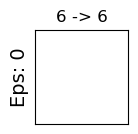

In [37]:
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel(f"Eps: {epsilons[i]}", fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title(f"{orig} -> {adv}")
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()